<a href="https://colab.research.google.com/github/pareshrchaudhary/mobile_sensing_robotics/blob/main/Bayes_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bayes Filter

**State Estimation** - Estimate the state x of a system at a certain point in time given observations z and controls u


**Recursive Bayes Filter** - A framework for recursive state estimation

$$bel(x_t) = p(x_t | z_{1:t}, u_{1:t})$$

Applying Bayes rule with background info

$${bel(x_t)} = \underset{\text{normalizing term}}{\underbrace{\eta}} \, \underset{\text{likelihood (sensor)}}{\underbrace{p(z_t | x_t, z_{1:t-1}, u_{1:t})}} \, \underset{\text{prior (P(state))}}{\underbrace{p(x_t | z_{1:t-1}, u_{1:t})}}$$

Markov assumption says that given I know the current state of the system $x_t$, what happend in the past $z_{1:t-1}, u_{1:t}$ is decoupled/independent of the future.

$$bel(x_t) = \underset{\text{normalizing}}{\underbrace{\eta}} \, \underset{\text{likelihood}} {\underbrace{p(z_t | x_t)}} \, \underset{\text{prior}}{\underbrace{p(x_t | z_{1:t-1}, u_{1:t})}}$$

Applying law of total probability and Markov assumption and ignoring that latest action is going to affect the present state

$$bel(x_t) = \underset{\text{normalizing}}{\underbrace{\eta}} \, \underset{\text{likelihood}}{\underbrace{p(z_t | x_t)}} \, \int \underset{\text{probability of } x_{t}} {\underbrace{p(x_t | x_{t-1}, u_{1:t})}} \, \underset{\text{belief of } x_{t-1}} {\underbrace{p(x_{t-1} | z_{1:t-1}, u_{1:t-1})}} \,dx_{t-1}$$

Integral term contains belief of previous point of time, so final expression looks

$$bel(x_t) = \underset{\text{normalizing}}{\underbrace{\eta}} \, \underset{\text{likelihood}}{\underbrace{p(z_t | x_t)}} \, \int \underset{\text{probability of } x_{t}} {\underbrace{p(x_t | x_{t-1}, u_{1:t})}} \, \underset{\text{previous belief}}{\underbrace{bel(x_{t-1})}} \,dx_{t-1}$$

**Prediction Step:** The integral term, because based on action command it advances the previous belief and predicts where the system will be in the future. The probability term is known as *motion model*.

$$ \text{Motion Model - } \underset{\text{probability of } x_{t}} {\underbrace{p(x_t | x_{t-1}, u_{1:t})}}  $$

**Correction Step:** Non integral term, because once we have observation in new state we can have a correction in our prediction. The probability term is known as *observation model*

$$ \text{Sensor Model - } \underset{\text{likelihood}}{\underbrace{p(z_t | x_t)}} $$

There are different realizations of Bayes filter that we will study later e.g. EKF, particle filter

# Exercise 2.1

---



## Motion model

Consider a robot that navigates in a **discrete 1D grid world** composed by 15 cells as the one illustrated below.

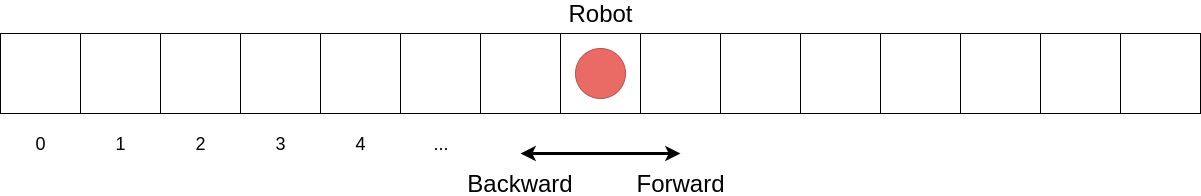

In this world, the robot can move forward ($F$) or backward ($B$).

Given a command, it moves according to the following motion model:

- with probability **0.7**, it moves in the **correct direction** (i.e. $F\rightarrow F, B\rightarrow B$);
- with probability **0.2** or if the command cannot be exectuted (e.g. end of the world!), it **does not move**;
- with probability **0.1**, it moves in the **opposite direction** (i.e. $F\rightarrow B, B\rightarrow F$).

The initial position of the robot is known and is at cell `7`.

In [1]:
! git clone https://github.com/pareshrchaudhary/mobile_sensing_robotics.git

Cloning into 'mobile_sensing_robotics'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 140 (delta 61), reused 60 (delta 16), pack-reused 0
Receiving objects: 100% (140/140), 14.38 MiB | 15.65 MiB/s, done.
Resolving deltas: 100% (61/61), done.


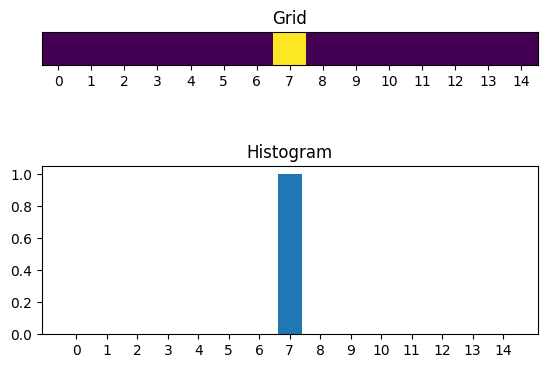

In [2]:
from mobile_sensing_robotics.utils.ex2 import *
import numpy as np
%matplotlib inline

belief = np.zeros(15)

# initial known position
x_start = 7
belief[x_start] = 1.0

plot_belief(belief)

The plots above shows the initial belief about the position of the robot both as weights in the grid world and as a histogram.

1. **[4.0]** Implement the motion model (`motion_model`) and estimate recursively the belief about the position of the robot after executing the following sequence of commands:
$$ F, F, F, F, B, B, F, F, B $$
Plot the final belief using the `plot_belief` function.

In [3]:
def motion_model(action, belief):
  """
  The probabilities for each cell are updated based on the possibility of
  the system moving forward, staying in the same position, or moving backward.
  The reason for updating probabilities for all cells is to capture the
  potential influence of the motion on the entire belief distribution.
  """
  p_correct_direction = 0.7
  p_opposite_direction = 0.1
  p_no_move = 0.2

  belief_out = np.zeros_like(belief)

  if action == "F":
      belief_out[1:-1] = p_correct_direction * belief[:-2] + p_opposite_direction * belief[2:] + p_no_move * belief[1:-1]
      belief_out[0] = p_opposite_direction * belief[1] + p_no_move * belief[0]
      belief_out[-1] = p_correct_direction * belief[-2] + p_no_move * belief[-1]

  elif action == "B":
      belief_out[1:-1] = p_correct_direction * belief[2:] + p_opposite_direction * belief[:-2] + p_no_move * belief[1:-1]
      belief_out[0] = p_correct_direction * belief[1] + p_no_move * belief[0]
      belief_out[-1] = p_opposite_direction * belief[-2] + p_no_move * belief[-1]

  return belief_out

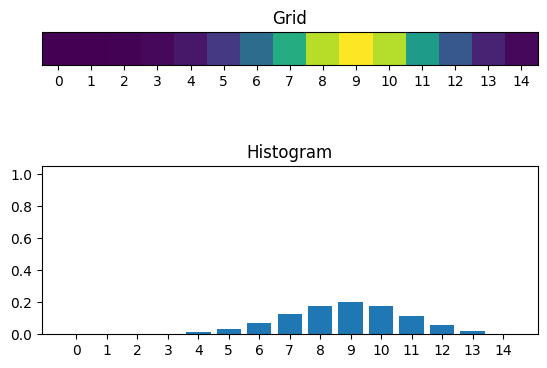

In [3]:
actions = ["F","F","F","F","B","B","F","F","B"]
belief_init = np.copy(belief)

for action in actions:
  belief = motion_model(action, belief)

plot_belief(belief)

---

## Bayes filter

Now, assume that we equipped the robot with a sensor which is able to recognize the color of the floor on which the robot navigates.

The floor can be either black **(0)** or white **(1)** and the environment looks as follows:

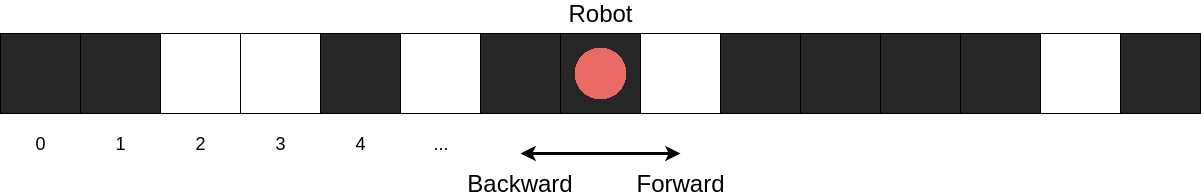

The map of the floor colors is stored in `world.data`.

The sensor is able to recognize that:

- a tile is **white** with probability **0.7**
- a tile is **black** with probability **0.9**

The robot starts again in `7`. It executes the same commands as in 1. and follows the same motion model.

During navigation, it makes the observations stored in `observations.data`.

Thanks to its new sensor, it can now use the obrvations to estimate its position in the world.


2. **[3.5]** Implement the function `sensor_model` which defines the sensor model and implement `recursive_bayes_filter` fucntion which estimates recursively the belief about the position of the robot incorporating the observations.
Plot the final belief using the `plot_belief` function.

3. **[0.5]** Print out the most likely position and the corresponding probability.

In [8]:
def sensor_model(observation, belief, world):
  p_white = 0.7
  p_black = 0.9

  if observation == 0:
    belief_out = p_black * (world == 0) * belief + (1 - p_white) * (world == 1) * belief
  else:
    belief_out = p_white * (world == 1) * belief + (1 - p_black) * (world == 0) * belief

  return belief_out / np.sum(belief_out)

In [9]:
def recursive_bayes_filter(actions, observations, belief, world):
  sensor_belief = sensor_model(observations[0], belief, world)

  for i, action in enumerate(actions):
    motion_belief = motion_model(action, sensor_belief)
    sensor_belief = sensor_model(observations[i + 1], motion_belief, world)

  return sensor_belief

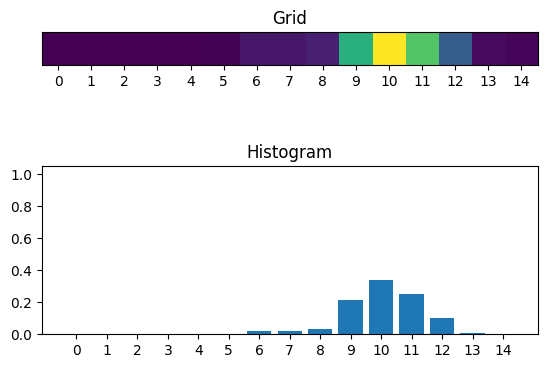

In [5]:
f1 = open("./mobile_sensing_robotics/data/world.data","r")
f2 = open("./mobile_sensing_robotics/data/observations.data","r")
world = np.array(f1.readlines()[0].split(','), dtype='int32')
observations = np.array(f2.readlines()[0].split(','), dtype='int32')
belief = belief_init

result = recursive_bayes_filter(actions, observations, belief, world)
plot_belief(result)

In [6]:
print(f"The most likely position according to our state estimation model is: {np.argmax(result)} and the value is: {result[np.argmax(result)]}")

The most likely position according to our state estimation model is: 10 and the value is: 0.34148194893857614


---

## Bayes filter with unknown initial position


What if the initial position of the robot is unknown?

Consider the same task as in 2. but with the initial belief about the position of the robot being an uniform probability distribution over the world.

2. **[1.5]** Plot the final belief about the position of the robot.

3. **[0.5]** Print out the most likely position and the corresponding probability.

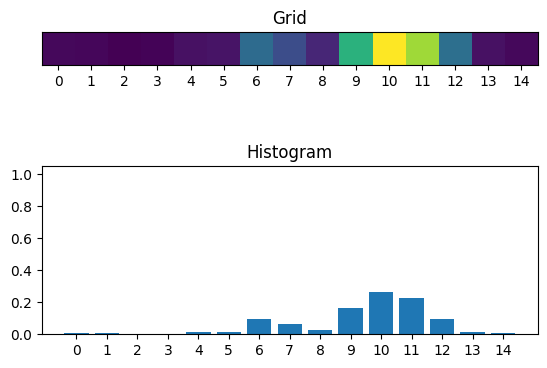

In [7]:
uniform_belief = np.array([1/15]*15)

result_uni = recursive_bayes_filter(actions, observations, uniform_belief, world)
plot_belief(result_uni)

In [8]:
print(f"The most likely position according to our state estimation model is: {np.argmax(result_uni)} and the value is: {result_uni[np.argmax(result_uni)]}")

The most likely position according to our state estimation model is: 10 and the value is: 0.26142559908608154
